In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from scoreEtudiant import *
from annexe import *
import tqdm
import math as m

# Résolution de TPTW (travel problem with time window) avec métahéuristique du recuit simulé

In [12]:
# configuration
T_init = 10
lbd = 0.9999
nb_iter = 50000
path_to_instance = "data/inst1"

def f(temp, iter):
    # if iter % 10000 == 0:
    #     return T_init / (iter // 10000 +1)
    return temp * lbd

In [13]:
def evaluation_model(liste_prop, alpha=50):
    """
    évalue le modèle en fonction de la liste des propositions
    la formule choisie est la somme des distances plus une pénalité binaire pour chaque consigne de temps non respectée
    :rq: on utilise les variables globales instance et graphe_matrix
    """
    global instance, graphe_matrix
    score = 0
    score_without_punition = 0
    assert liste_prop[0] == "1", "La première ville n'est pas 1 : {}".format(liste_prop)
    time_axis = 0
    valide = len(liste_prop)
    for i, prop in enumerate(liste_prop):
        if i == 0: continue
        # on commence par aller jusqu'à la ville i
        time_axis += graphe_matrix[int(liste_prop[i-1])][int(liste_prop[i])]

        # si on est arrivé trop tôt, on attend
        if time_axis < instance[prop]["wstart"]:
            time_axis = instance[prop]["wstart"]

        # on ajoute le cout au score
        score += graphe_matrix[int(liste_prop[i-1])][int(prop)]
        score_without_punition += graphe_matrix[int(liste_prop[i-1])][int(prop)]

        # on ajoute une pénalité si on arrive trop tard (consigne de temps non respectée)
        if time_axis > instance[prop]["wend"]:
            score += alpha
            valide -= 1
    
    return score, valide, score_without_punition, time_axis

    

## préparation de l'instance pré-résolution

In [14]:
# calcul de la matrice des distances du graphe
instance = load_instance(path_to_instance)
graphe_matrix = compute_dist_mat(instance)
print("Matrice des distances calculée")
print(np.mean(graphe_matrix[graphe_matrix != 0]))
print(np.max((graphe_matrix)))
print(np.min((graphe_matrix)))


Matrice des distances calculée
22.70952380952381
57.0
0.0


## Récuit simulé
On réalise ici l'algorithme du recuit-simulé.

In [15]:
# initialisation de l'algorithme
modele = list(instance.keys())
modele = ["1"] + random.sample(modele[1:], len(modele)-1)
print(modele)

temperature = T_init
proba = 1

modele_kept = modele.copy()
score_kept, valide, score_without_punition,  time_axis = evaluation_model(modele_kept)
score_kept

# initialisation des historiques (pour affichage graphique ensuite)
historique_score = [score_kept]
historique_temperature = [temperature]
historique_score_kept = [score_kept]
historique_proba = [1]
historique_modele_valide = [valide]
historique_time_axis = [time_axis]
historique_score_without_punition = [score_without_punition]

['1', '11', '19', '10', '8', '2', '12', '18', '15', '5', '20', '6', '13', '21', '9', '16', '17', '4', '14', '7', '3']


In [16]:
for iteration in tqdm.tqdm(range(nb_iter)):
    # on commence par appliquer une transformation aléatoire
    modele = transformee_pick_2(modele_kept)# , instance=instance, graphe_matrix=graphe_matrix)

    # on détermine le score du modèle ainsi modifié
    score, valide, score_without_punition, time_axis = evaluation_model(modele)

    # on accepte ou non la modification (recuit simulé)
    if score < score_kept:
        modele_kept = modele.copy()
        score_kept = score
    else:
        # la proba est calculée ici pour des soucis de cohérences avec les historiques
        proba = np.exp(-(score-score_kept)/temperature)
        if bernoulli.rvs(proba, size=1):    # variable de bernoulli
            modele_kept = modele.copy()
            score_kept = score

    # on met à jour les historiques
    historique_score.append(score)
    historique_temperature.append(temperature)
    historique_score_kept.append(score_kept)
    historique_proba.append(proba)
    historique_modele_valide.append(valide)
    historique_time_axis.append(time_axis)
    historique_score_without_punition.append(score_without_punition)

    # on met à jour la température puis ça repart
    temperature = f(temperature, iteration)
print("[INFO] Simulation terminée")
print("Meilleur score : ", score_kept)
print("Meilleur modèle : ", modele_kept)

100%|██████████| 50000/50000 [00:08<00:00, 5928.32it/s]

[INFO] Simulation terminée
Meilleur score :  483.0
Meilleur modèle :  ['1', '17', '10', '20', '18', '19', '11', '12', '13', '7', '14', '8', '3', '5', '6', '9', '21', '4', '2', '16', '15']


## Affichage des graphiques

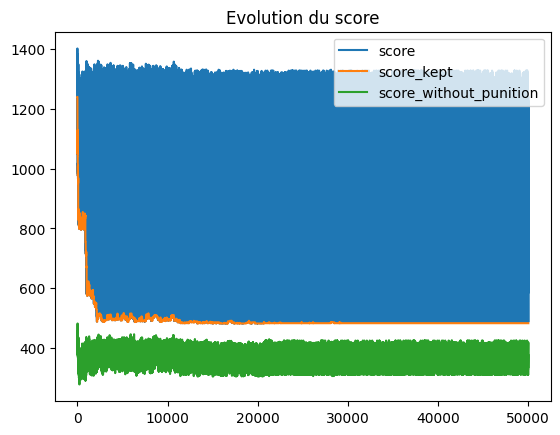

In [17]:
plt.plot(historique_score, label="score")
plt.plot(historique_score_kept, label="score_kept")
plt.plot(historique_score_without_punition, label="score_without_punition")
plt.title("Evolution du score")
plt.legend()

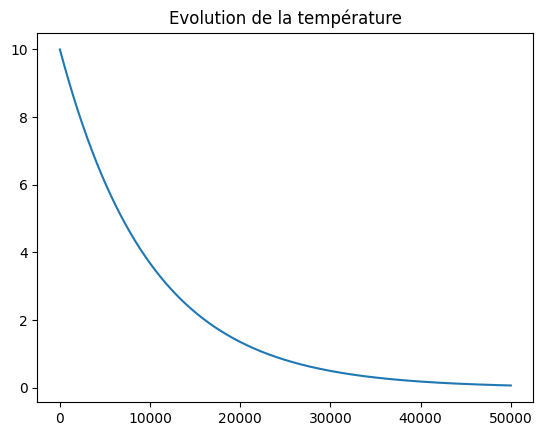

In [18]:
plt.close()
plt.plot(historique_temperature)
plt.title("Evolution de la température")
plt.show()

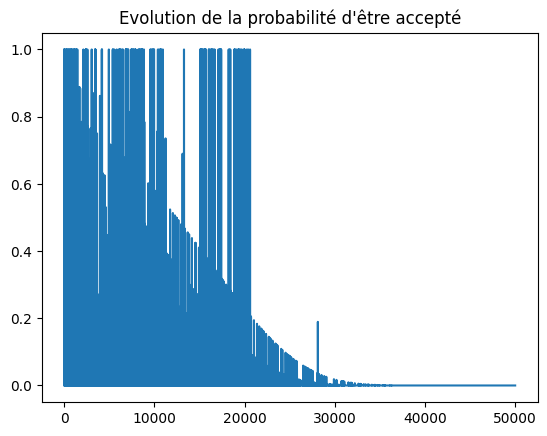

[1, 9.213600834566135e-08, 0.40653306645861664, 0.40653306645861664, 0.09065264681533718, 0.6702127765940383, 0.6702127765940383, 0.24638983700900569, 0.406313499100031, 0.49630716876020575, 0.24628629221619927, 0.24628629221619927, 0.24628629221619927, 0.020147339311141266, 0.496133300518655, 0.496133300518655, 0.5483175328110087, 3.297410085988972e-08, 3.297410085988972e-08, 3.297410085988972e-08, 6.579320889941923e-11, 0.054704675687008625, 1.7918696902416993e-08, 0.3670700665847488, 0.0006009249893026212, 0.12184003227926345, 4.3997519231101396e-07, 2.6341844773198654e-10, 0.05459347152035295, 0.6056808801478697, 0.33180932745292235, 0.0014743615103203138, 0.060283677308744794, 0.006630822468287478, 3.913708001494963e-08, 3.913708001494963e-08, 1.5894646312565333e-07, 1.0, 5.73886640264822e-10, 5.73886640264822e-10, 5.73886640264822e-10, 0.05438734323410486, 6.466389734644649e-06, 6.466389734644649e-06, 6.466389734644649e-06, 0.024323393743828022, 1.030817619326476e-09, 8.482163369

In [19]:
plt.close()
plt.plot(historique_proba)
plt.title("Evolution de la probabilité d'être accepté")
plt.show()
print(historique_proba)

Text(0.5, 1.0, 'Evolution de la validité du modèle')

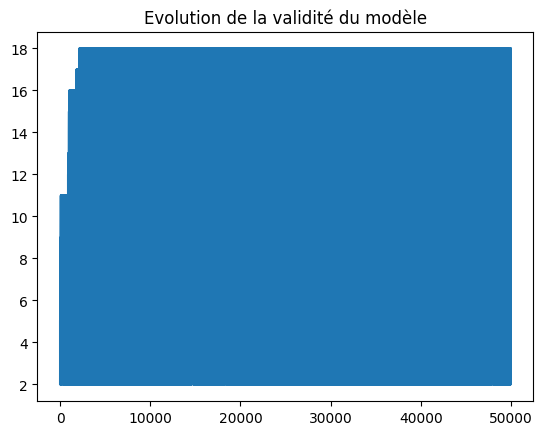

In [20]:
plt.close()
plt.plot(historique_modele_valide)
plt.title("Evolution de la validité du modèle")


Text(0.5, 1.0, 'Evolution du time_axis')

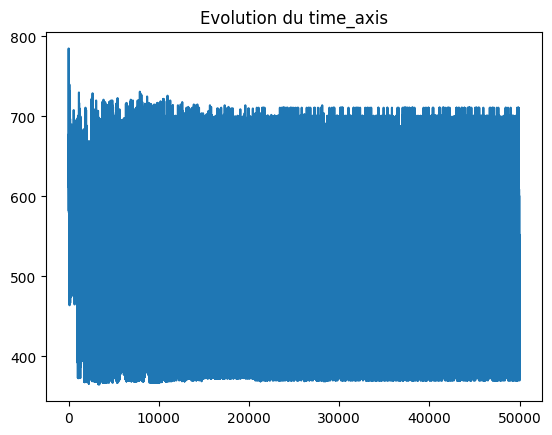

In [21]:
plt.close()
plt.plot(historique_time_axis)
plt.title("Evolution du time_axis")